# Launches Data Preprocessing Notebook 🚀👽🏰

<div class="alert alert-block alert-info">
⚠️ Download the data before running this notebook. Check the documentation.
</div>

## Data Loading 📥

In this cell, we load the launches raw dataset:

- **Launches Data:** Loaded from a JSON file.

In [53]:
import os
import json

# ============================================================
# SETUP: Define output directory relative to this script
# ============================================================
# Get the absolute path of the directory where this script is located
# In a notebook, __file__ is not defined so we use os.getcwd() as a fallback.
try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    BASE_DIR = os.getcwd()

# Define the folder where raw data is stored (assumed to be "../data/raw")
RAW_DIR = os.path.join(BASE_DIR, "..", "data", "raw")

# Define the folder where processed data will be saved (assumed to be "../data/processed")
PROCESSED_DIR = os.path.join(BASE_DIR, "..", "data", "processed")
os.makedirs(PROCESSED_DIR, exist_ok=True)  # Create the folder if it doesn't exist
OUTPUT_FILE = os.path.join(PROCESSED_DIR, "spacedevs_launches_processed.json") # Build the absolute path for the output file

# Build the absolute paths for each dataset
launches_path = os.path.join(RAW_DIR, "spacedevs_launches.json")

# Load SpaceX launches data from JSON using the absolute path
with open(launches_path, "r") as f:
    launches = json.load(f)

# Extract the list of launches; ignore the "offset" for cleaning purposes.
results = launches.get("results", [])
print(f"Loaded {len(results)} launches from raw data.")

print("✅ Datasets loaded!")

Loaded 7418 launches from raw data.
✅ Datasets loaded!


## Fixing Datetime Format for Lauches Data 📆📍

In [54]:
from datetime import datetime

def convert_datetime(iso_str):
    """
    Convert an ISO datetime string like "2006-03-24T22:30:00.000Z"
    to the format "MM/DD/YYYY HH:MM".
    """
    try:
        dt = datetime.strptime(iso_str, "%Y-%m-%dT%H:%M:%S.%fZ")
    except ValueError:
        # Fallback if microseconds are not provided:
        dt = datetime.strptime(iso_str, "%Y-%m-%dT%H:%M:%SZ")
    return dt.strftime("%m/%d/%Y %H:%M")

## Selecting Only Relevant Variables From Raw Data

In [55]:
# Create list to append processed launches
processed_launches = []

for launch in results:
    processed = {}
    processed["id"] = launch.get("id")
    processed["name"] = launch.get("name")
    
    net = launch.get("net")
    processed["net"] = convert_datetime(net) if net else None
    
    # Extract status name from the nested status object, using a fallback empty dict if needed.
    status = launch.get("status") or {}
    processed["status"] = status.get("abbrev")
    
    # Extract rocket id from the nested rocket object.
    rocket = launch.get("rocket") or {}
    processed["rocket_id"] = rocket.get("id")
    
    # Extract pad details: id, name, latitude, and longitude.
    pad = launch.get("pad") or {}
    processed["pad"] = {
        "id": pad.get("id"),
        "name": pad.get("name"),
        "latitude": pad.get("latitude"),
        "longitude": pad.get("longitude"),
        "country": pad.get("country")
    }
    
    # Extract mission details: name, type, and description.
    mission = launch.get("mission") or {}
    processed["mission"] = {
        "name": mission.get("name"),
        "type": mission.get("type"),
        "description": mission.get("description")
    }
    
    # Extract launch service provider info.
    lsp = launch.get("launch_service_provider") or {}
    processed["launch_service_provider"] = {
        "id": lsp.get("id"),
        "name": lsp.get("name")
    }
    
    # Keep the URL for more info.
    processed["url"] = launch.get("url")
    
    processed_launches.append(processed)

print(f"✅ Preprocessed {len(processed_launches)} launches!")

✅ Preprocessed 7418 launches!


## Saving the Processed Lauches and Launchpads Data 💾

In [56]:
# Save the updated launches back to a JSON file (no spaces, no identation)
with open(OUTPUT_FILE, "w") as f:
    json.dump(processed_launches, f, separators=(',', ':'))

print("💾 Saved processed launches dataset!")

💾 Saved processed launches dataset!


## Making Some Preliminar Analysis on the Processed Launches 📉

In [57]:
import pandas as pd

# Create DataFrame from launches data
launches_df = pd.DataFrame(processed_launches)

# Our cleaned data has 'net' in "MM/DD/YYYY HH:MM" format.
launches_df['net'] = pd.to_datetime(launches_df['net'], format="%m/%d/%Y %H:%M", errors='coerce')

# Show basic info about the data
print("Total launches:", len(launches_df),"\n")
print(launches_df.head())

Total launches: 7418 

                                     id                        name  \
0  e3df2ecd-c239-472f-95e4-2b89b4f75800  Sputnik 8K74PS | Sputnik 1   
1  f8c9f344-a6df-4f30-873a-90fe3a7840b3  Sputnik 8K74PS | Sputnik 2   
2  535c1a09-97c8-4f96-bb64-6336d4bcb1fb         Vanguard | Vanguard   
3  1b9e28d0-c531-44b0-9b37-244e62a6d3f4         Juno-I | Explorer 1   
4  48bc7deb-b2e1-46c2-ab63-0ce00fbd192b         Vanguard | Vanguard   

                  net   status  rocket_id  \
0 1957-10-04 19:28:00  Success       3003   
1 1957-11-03 02:30:00  Success       3004   
2 1957-12-06 16:44:00  Failure       3005   
3 1958-02-01 03:47:00  Success       3006   
4 1958-02-05 07:33:00  Failure       3007   

                                                 pad  \
0  {'id': 32, 'name': '1/5', 'latitude': 45.92, '...   
1  {'id': 32, 'name': '1/5', 'latitude': 45.92, '...   
2  {'id': 118, 'name': 'Launch Complex 18A', 'lat...   
3  {'id': 193, 'name': 'Launch Complex 26A', 'lat...   

## How Many Launches Occur Per Year and Per Month? 📆

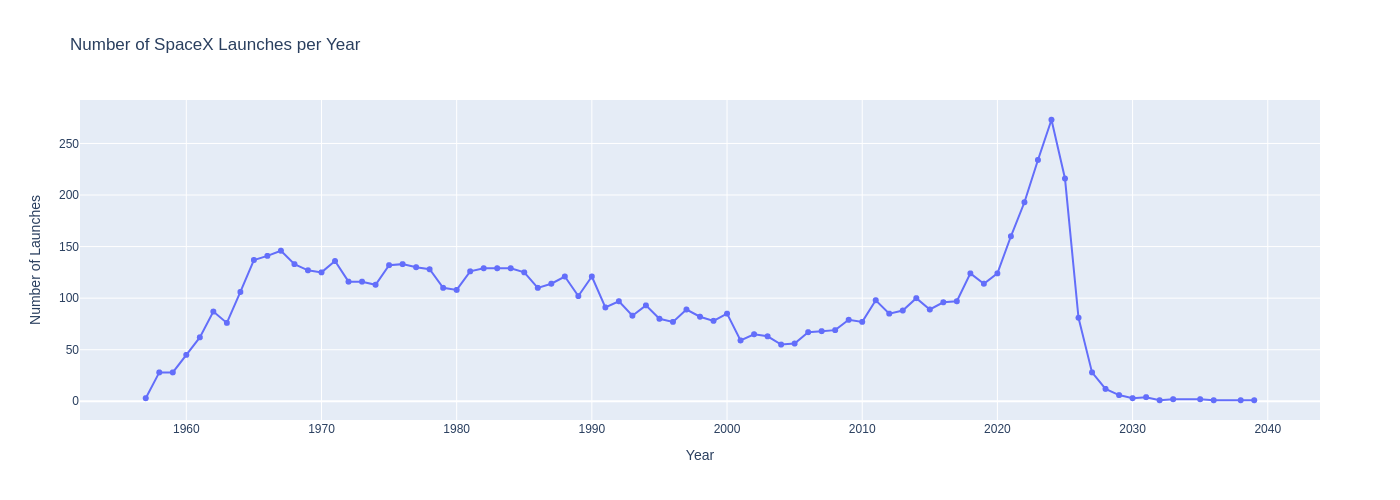

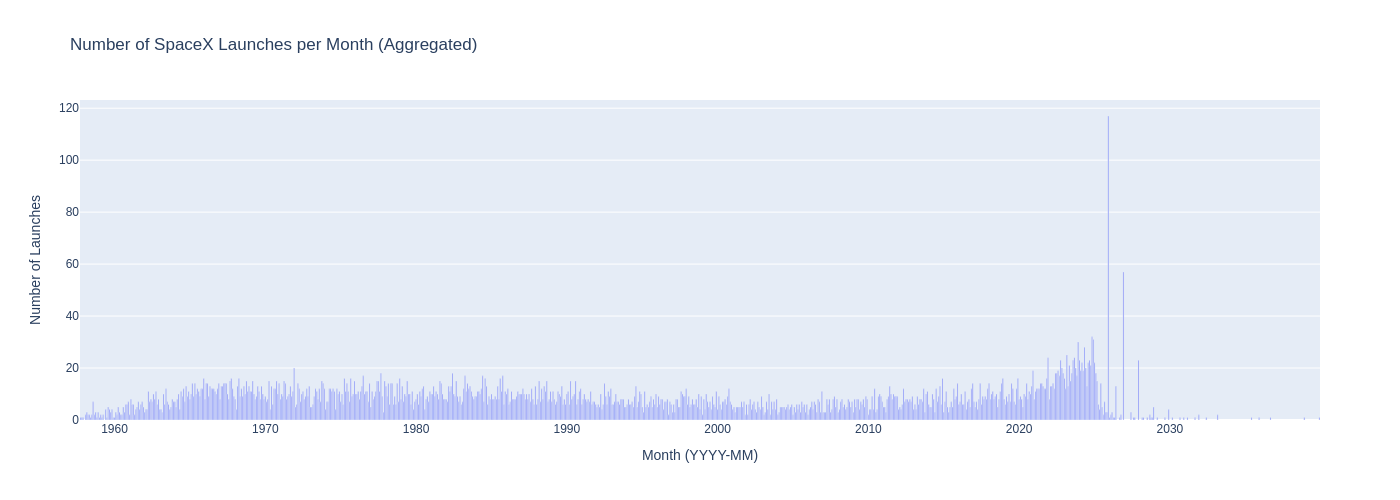

In [58]:
import plotly.express as px

# Create a column for year and month
launches_df['year'] = launches_df['net'].dt.year
launches_df['month'] = launches_df['net'].dt.to_period('M').astype(str)

# Count launches per year
launches_per_year = launches_df.groupby('year').size().reset_index(name='launch_count')
fig_year = px.line(
    launches_per_year, 
    x='year', 
    y='launch_count',
    markers=True,
    title="Number of SpaceX Launches per Year",
    labels={'year': 'Year', 'launch_count': 'Number of Launches'},
    width=1400
)

# Remove renderer="png" to have an interactive image
fig_year.show(renderer="png")

# Count launches per month (aggregated across all years)
launches_per_month = launches_df.groupby('month').size().reset_index(name='launch_count')
fig_month = px.bar(
    launches_per_month, 
    x='month', 
    y='launch_count',
    title="Number of SpaceX Launches per Month (Aggregated)",
    labels={'month': 'Month (YYYY-MM)', 'launch_count': 'Number of Launches'},
    width=1400
)

# Remove renderer="png" to have an interactive image
fig_month.show(renderer="png")

## How Many Launches Succeeded? 🔍

            status  count
0          Success   6549
1          Failure    505
2              TBD    318
3  Partial Failure     34
4               Go      8
5              TBC      4


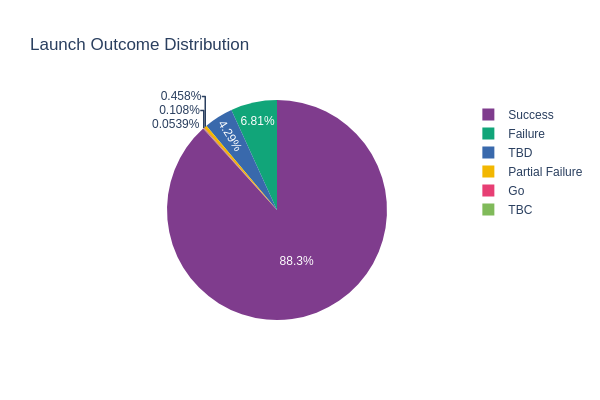

In [59]:
# Count the number of launches per status
status_counts = launches_df['status'].value_counts().reset_index()
status_counts.columns = ['status', 'count']
print(status_counts)

fig_status = px.pie(
    status_counts,
    names='status',
    values='count',
    title="Launch Outcome Distribution",
    color_discrete_sequence=px.colors.qualitative.Bold,
    width=600,
    height=400
)

# Remove renderer="png" to have an interactive image
fig_status.show(renderer="png")

## Which Launchpads Have Hosted the Most Launches? 🚀

                    pad_name  launch_count
0                        1/5           487
23                      31/6           427
32                43/4 (43R)           323
29                      41/1           310
174  Space Launch Complex 40           293


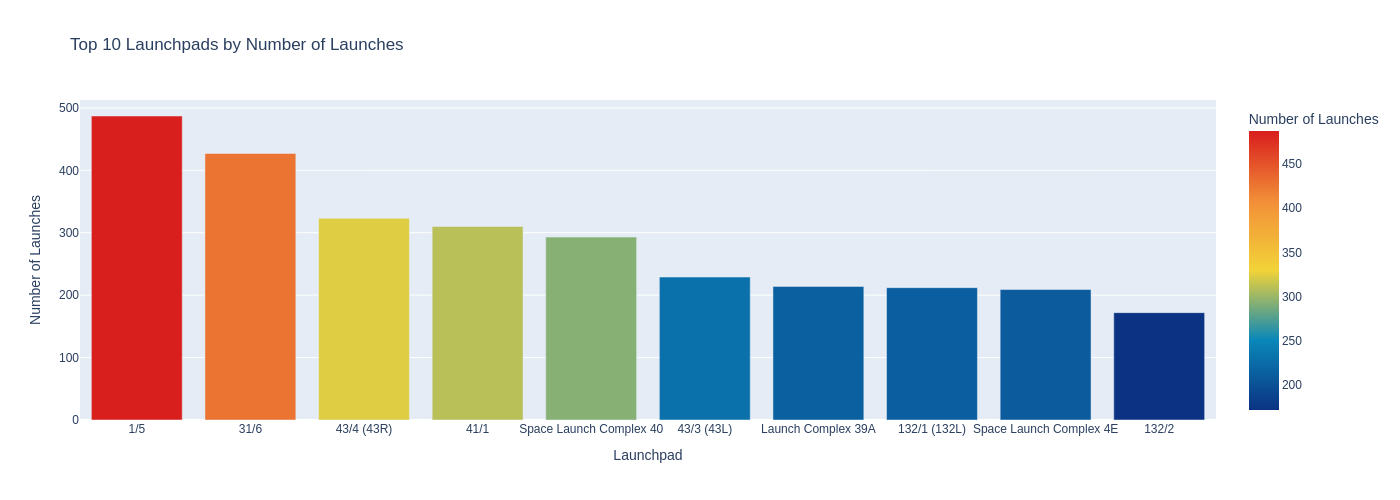

In [60]:
# Extract launchpad information from the nested "pad" dictionary.
# We create a new DataFrame with launchpad id and name.
launches_df['pad_id'] = launches_df['pad'].apply(lambda x: x.get("id") if isinstance(x, dict) else None)
launches_df['pad_name'] = launches_df['pad'].apply(lambda x: x.get("name") if isinstance(x, dict) else None)

# Count launches per launchpad
launchpad_counts = launches_df.groupby('pad_name').size().reset_index(name='launch_count')
launchpad_counts = launchpad_counts.sort_values(by='launch_count', ascending=False)
print(launchpad_counts.head())

fig_launchpads = px.bar(
    launchpad_counts.head(10),
    x='pad_name',
    y='launch_count',
    title="Top 10 Launchpads by Number of Launches",
    labels={'pad_name': 'Launchpad', 'launch_count': 'Number of Launches'},
    color='launch_count',
    color_continuous_scale='Portland',
    width=1400
)

# Remove renderer="png" to have an interactive image
fig_launchpads.show(renderer="png")

## Where Are Located the Launchpads? 🌍

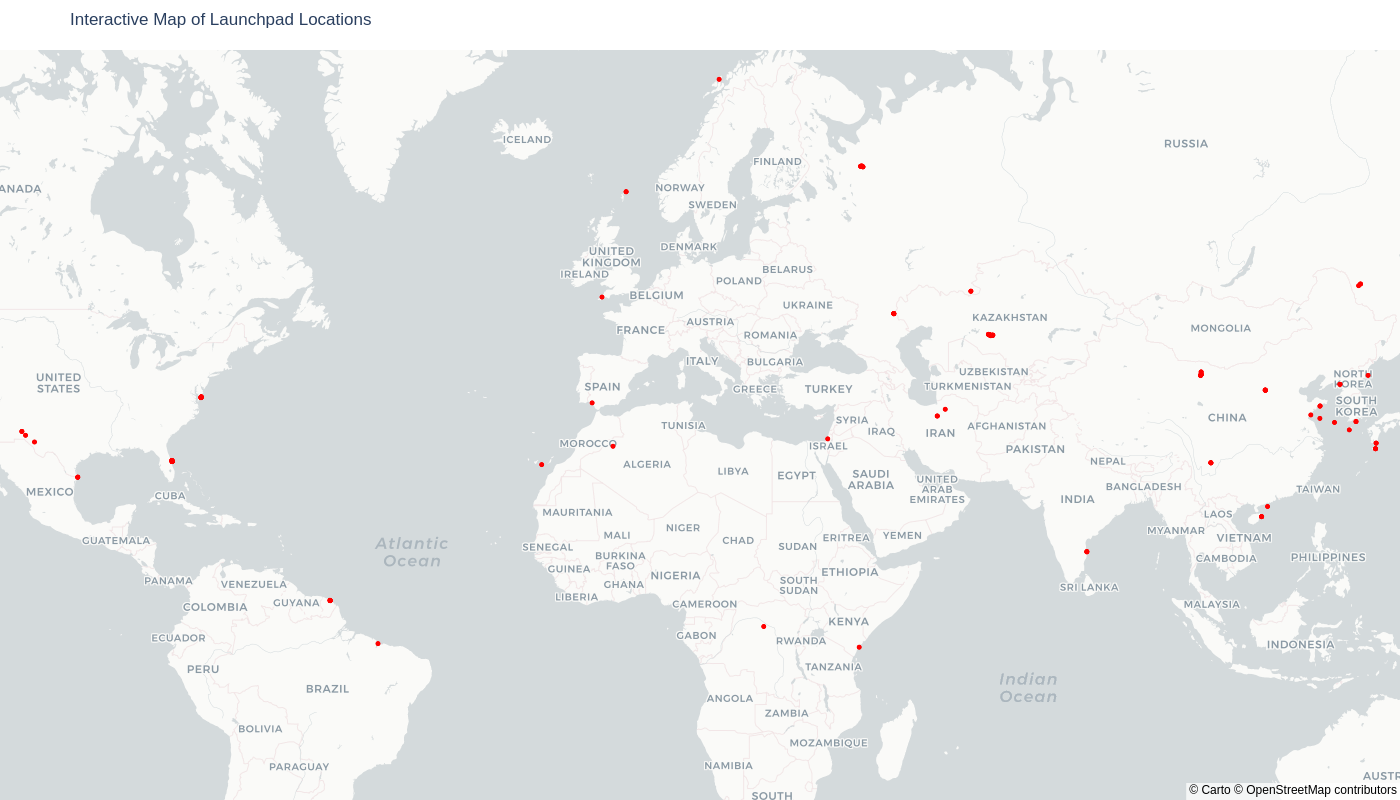

In [61]:
# Extract latitude and longitude for each launch from the nested pad dictionary.
launches_df['pad_lat'] = launches_df['pad'].apply(lambda x: x.get("latitude") if isinstance(x, dict) else None)
launches_df['pad_lon'] = launches_df['pad'].apply(lambda x: x.get("longitude") if isinstance(x, dict) else None)

# Filter out launchpads that have "landing site" in their name (case insensitive)
launchpads_map_df = launches_df[~launches_df['pad_name'].str.contains("landing site", case=False, na=False)].copy()

# Drop rows with missing coordinates
launchpads_map_df = launchpads_map_df.dropna(subset=['pad_lat', 'pad_lon']).drop_duplicates(subset=['pad_id'])

fig_map = px.scatter_mapbox(
    launchpads_map_df,
    lat="pad_lat",
    lon="pad_lon",
    hover_name="pad_name",
    hover_data=["pad_id"],
    color_discrete_sequence=["red"],
    zoom=2,
    height=800,
    width=1400,
    title="Interactive Map of Launchpad Locations"
)

fig_map.update_layout(mapbox_style="carto-positron", margin={"r":0,"t":50,"l":0,"b":0})

# Remove renderer="png" to have an interactive image
fig_map.show(renderer="png")

## How Many Launches per Country? 🚀

In [62]:
# Extract pad details: id, name, latitude, longitude, and country (if available).
def extract_pad_info(pad):
    if isinstance(pad, dict):
        # Try multiple keys for country if needed
        country = None
        if "country" in pad and isinstance(pad["country"], dict):
            country = pad["country"].get("name")
        elif "country_name" in pad:
            country = pad.get("country_name")
        return {
            "id": pad.get("id"),
            "name": pad.get("name"),
            "latitude": pad.get("latitude"),
            "longitude": pad.get("longitude"),
            "country": country
        }
    else:
        return None

# Create new columns for pad info
launches_df['pad_info'] = launches_df['pad'].apply(extract_pad_info)

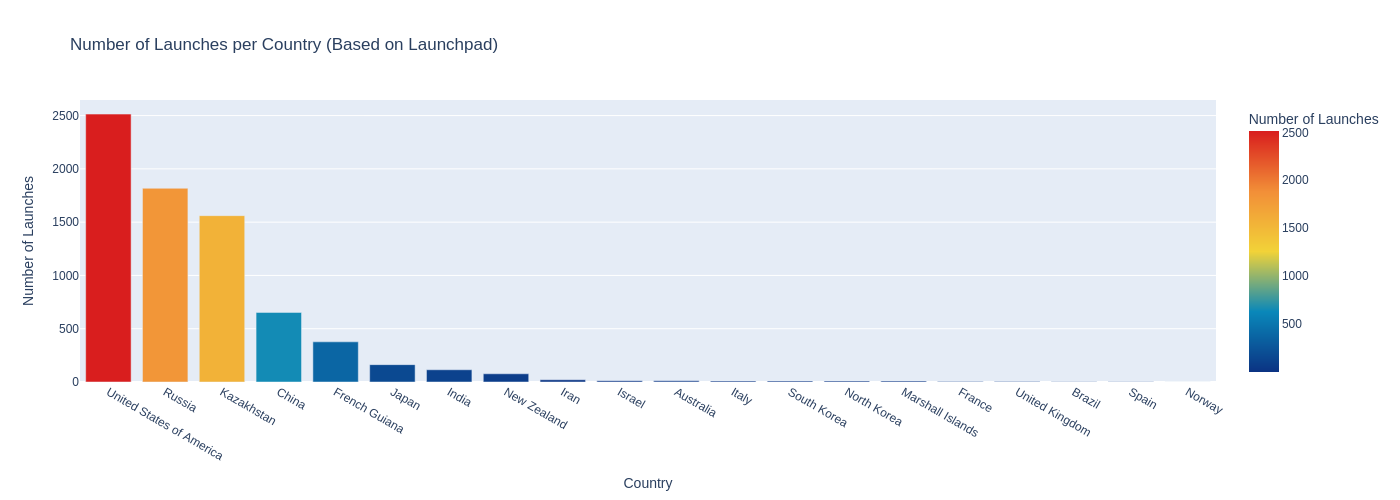

In [63]:
# Extract pad country for each launch from the nested pad dictionary.
launches_df['pad_country'] = launches_df['pad_info'].apply(lambda x: x.get("country") if isinstance(x, dict) else None)

# Group by pad country and count launches
launches_by_country = launches_df.groupby('pad_country').size().reset_index(name='launch_count')
launches_by_country = launches_by_country.dropna(subset=['pad_country'])

# Order the data descending by launch_count
launches_by_country = launches_by_country.sort_values(by='launch_count', ascending=False)

fig_country = px.bar(
    launches_by_country,
    x='pad_country',
    y='launch_count',
    title="Number of Launches per Country (Based on Launchpad)",
    labels={'pad_country': 'Country', 'launch_count': 'Number of Launches'},
    color='launch_count',
    color_continuous_scale='Portland',
    width=1400
)

# Remove renderer="png" to have an interactive image
fig_country.show(renderer="png")

## What are the Mission Types?

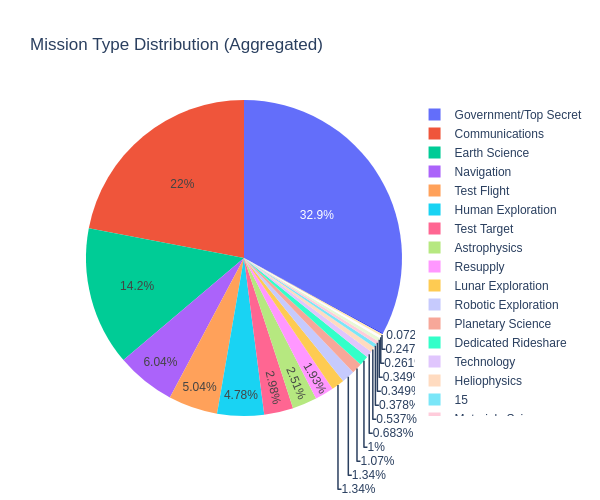


Aggregated mission type counts for pie chart:  mission_type
Government/Top Secret    2265
Communications           1514
Earth Science             977
Navigation                416
Test Flight               347
Human Exploration         329
Test Target               205
Astrophysics              173
Resupply                  133
Lunar Exploration          92
Robotic Exploration        92
Planetary Science          74
Dedicated Rideshare        69
Technology                 47
Heliophysics               37
                           26
Materials Science          24
Suborbital                 24
Biology                    18
Tourism                    17
Other                       5
Name: count, dtype: int64


In [64]:
# %% [code]
# Extract mission type from the mission dictionary
def extract_mission_type(mission):
    if isinstance(mission, dict):
        return mission.get("type")
    return None

launches_df['mission_type'] = launches_df['mission'].apply(extract_mission_type)

# Count frequencies
mission_counts = launches_df['mission_type'].value_counts(dropna=True)

# Define threshold: e.g., if a mission type appears less than 10 times, aggregate as "Other"
threshold = 10
aggregated_mission_type = mission_counts.copy()
aggregated_mission_type[aggregated_mission_type < threshold] = 0
other_count = mission_counts[mission_counts < threshold].sum()

# Build a new series for plotting
plot_data = mission_counts[mission_counts >= threshold].copy()
if other_count > 0:
    plot_data["Other"] = other_count


fig_pie = px.pie(
    names=plot_data.index,
    values=plot_data.values,
    title="Mission Type Distribution (Aggregated)",
    width=600,
    height=500
)

# Remove renderer="png" to have an interactive image
fig_pie.show(renderer="png")

print("\nAggregated mission type counts for pie chart: ", plot_data)

## What are the Top Terms Used in the Launches' Descriptions? 💬

In [65]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np

# Extract all mission descriptions that are not null.
mission_descriptions = launches_df['mission'].apply(lambda m: m.get("description") if isinstance(m, dict) else None)
mission_descriptions = mission_descriptions.dropna()

# Clean the text: lowercase, remove punctuation, etc.
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

cleaned_descriptions = mission_descriptions.apply(clean_text)

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')
                 
# Use TF-IDF to find important terms.
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
tfidf_matrix = vectorizer.fit_transform(cleaned_descriptions)
feature_names = vectorizer.get_feature_names_out()

# Sum the TF-IDF score for each term
tfidf_sum = tfidf_matrix.sum(axis=0)
tfidf_scores = np.array(tfidf_sum).flatten()
terms_scores = list(zip(feature_names, tfidf_scores))
# Sort terms by score descending
terms_scores.sort(key=lambda x: x[1], reverse=True)

# Get top 20 terms
top_terms = terms_scores[:20]
print("Top 20 terms in mission descriptions:")
for term, score in top_terms:
    print(f"{term}: {score:.4f}")

# Use word frequency (Counter) for a simpler approach
all_words = " ".join(cleaned_descriptions.tolist()).split()
word_counts = Counter(all_words)
top_words = word_counts.most_common(20)
print("\nTop 20 frequent words in mission descriptions:")
for word, count in top_words:
    print(f"{word}: {count}")

Top 20 terms in mission descriptions:
satellite: 615.8177
reconnaissance: 438.1168
filmreturn: 389.3158
satellites: 313.8507
communications: 304.8860
military: 200.5357
geostationary: 196.3144
zenit: 177.0219
system: 171.3431
space: 156.2587
navigation: 145.5900
optical: 134.0914
orbit: 121.5043
series: 120.8357
earth: 120.5047
communication: 118.3674
early: 117.3569
mission: 115.3955
first: 113.8940

Top 20 frequent words in mission descriptions:
the: 10994
of: 5116
satellite: 4908
and: 4885
a: 3722
to: 3700
for: 2662
satellites: 2512
was: 2179
is: 2032
in: 1955
space: 1569
by: 1428
reconnaissance: 1371
on: 1278
communications: 1260
mission: 1233
system: 1184
with: 1145
orbit: 980


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lferr10/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lferr10/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## What are the Underlying Themes Observed in the Mission Descriptions? 🌌

In [68]:
from google import genai

# Extract mission descriptions from the launches DataFrame.
# We assume that 'mission' is a dictionary containing a "description" key.
mission_descriptions = launches_df['mission'].apply(lambda m: m.get("description") if isinstance(m, dict) else None)
mission_descriptions = mission_descriptions.dropna()

# Combine all mission descriptions into one large text block.
all_descriptions = " ".join(mission_descriptions.tolist())
print("Total length (in characters):", len(all_descriptions))

# Set the prompt that will be given to the LLM.
prompt = f"""
Please summarize the following text in clear, concise language.
The text displays multiple rocket launches' missions descriptions.
Focus on extracting the primary mission objectives, key accomplishments, and any notable challenges described in the text.
Your summary should capture the overall essence of the missions, highlighting the most important details while maintaining a professional tone.
The main question to answer is "What are the underlying themes observed in the mission descriptions that occurred from 1950s until now?"
Text: {all_descriptions}
"""

# Set your api-key.
client = genai.Client(api_key="your_api_key")

# Instantiate the LLM; you can adjust temperature and model as needed.
response = client.models.generate_content(
    model="gemini-2.0-flash", contents=prompt
)

Total length (in characters): 1171153
The mission descriptions from the 1950s to the present reveal several key themes in the evolution of space exploration:

1.  **Initial Technological Demonstrations:** Early missions focused on proving basic spaceflight capabilities, including launching satellites into orbit, testing launch vehicles, and developing communication systems. Notable examples include the Sputnik and Explorer series of satellites.

2.  **Scientific Exploration and Discovery:** A significant portion of missions aimed to gather scientific data about Earth, the Moon, other planets, and interplanetary space. These missions focused on studying radiation belts, magnetic fields, cosmic rays, cloud cover, and atmospheric density and solar activity.

3.  **Lunar Exploration:** A persistent theme involves lunar missions, initially focused on impacting or photographing the Moon, and eventually progressing to soft landings, surface exploration, and sample return. Failures were common

In [70]:
from IPython.display import Markdown as md

md(response.text)

The mission descriptions from the 1950s to the present reveal several key themes in the evolution of space exploration:

1.  **Initial Technological Demonstrations:** Early missions focused on proving basic spaceflight capabilities, including launching satellites into orbit, testing launch vehicles, and developing communication systems. Notable examples include the Sputnik and Explorer series of satellites.

2.  **Scientific Exploration and Discovery:** A significant portion of missions aimed to gather scientific data about Earth, the Moon, other planets, and interplanetary space. These missions focused on studying radiation belts, magnetic fields, cosmic rays, cloud cover, and atmospheric density and solar activity.

3.  **Lunar Exploration:** A persistent theme involves lunar missions, initially focused on impacting or photographing the Moon, and eventually progressing to soft landings, surface exploration, and sample return. Failures were common but led to significant successes like Luna 2 and Luna 3.

4.  **Planetary Exploration:** Missions to Venus and Mars were prominent, with objectives ranging from flybys and atmospheric studies to landing probes on the surface. Pioneer and Mariner programs are examples of such missions.

5.  **Reconnaissance and Surveillance:** A consistent theme is the use of satellites for reconnaissance purposes, exemplified by the Discoverer and Corona programs. These missions sought to gather intelligence through Earth observation and monitoring.

6.  **Communications and Navigation:** Early missions aimed to establish satellite-based communication and navigation systems. Projects like SCORE, Echo, Transit, and Molniya lay the foundation for modern satellite communications and navigation technologies.

7.  **Manned Spaceflight Development:** A substantial effort was dedicated to developing manned spaceflight capabilities, including testing spacecraft designs, launch escape systems, and the effects of space on living organisms. The Mercury, Vostok, Gemini, and Apollo programs are notable examples.

8.  **Meteorological Observations:** Early missions, such as the TIROS series, focused on weather monitoring and gathering data about the Earth's atmosphere. This focus continued with later meteorological satellite programs.

9.  **Testing Re-entry Technologies:** Early missions focused on understanding the conditions for spacecraft during re-entry, and validating the safety and performance for reentry with the ablative heat shield.

10. **Long-Duration Space Missions:** The Apollo and Salyut space station programs advanced the knowledge and effects of Long-Duration spaceflight on humans.

11. **International Cooperation and Competition:** Many missions represent efforts by the US and Soviet Union to compete in the space race, while others highlight increasing international collaboration in space exploration and research.

12. **Commercial Applications:** A gradual shift towards commercial applications of space technology emerged, including communication satellites for television and internet services, and commercial Earth imaging satellites.

13. **Continued Incremental Improvements:** A trend of technological iteration is seen. For example, the KH-4A mission continues to be developed after the KH-1, continuing with the Corona-program.

14. **Use of Satellites to Calibrate Earth Radars:** A trend for using launches for calibration purposes of Radar technology for early warning radars.

15. **Testing ASAT Technologies:** There are several Soviet ASAT tech demonstration satellites.

16. **Loss of Missions due to launch vehicle failures:** There are many mission descriptions that discuss launch vehicles failures, such as the failure to separate and engine failures.

17. **Many Missions with the objective to land on the Moon Fail:** Many of the Lunar missions failed either due to launch vehicle or capsule errors and launch a long road to success of Apollo 11 to land on the Moon.

18. **Miniaturization of components:** Satellites were heavy, big capsules and rockets into smaller more compact designs occurred more frequently as technology and science advanced.

19. **Data transfer/ relay technology experiments increased in demand to facilitate communications.** Satellites were launched to increase data transfer for commercial or Earth observation purposes.

20. **Space based internet satellite constellations increased, including the launch of first large scale satellites for SpaceX’s Starlink.**

21. **Private Companies participating in research, spaceflights and sample return missions, creating a new trend to make space more available to private sector for economic purposes.**
